<a href="https://colab.research.google.com/github/jarminett/Statistical_Learning_II/blob/main/Proyecto/CNN_Garabatos_(Doodles)_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Universidad Galileo** \\
Luis Florian, 0710082 \\
Statistical Learning II

**Descripción del proyecto**
Google lanzó un proyecto llamado QuickDraw que consiste en solicitar a personas del mundo dibujar a mano diferentes objetos.  En este proyecto por medio de una red convolucional haré una clasificación de los dibujos del cuerpo humano.


In [2]:
import os
import glob
import numpy as np
import tensorflow as tf
from tensorflow import keras 
from keras import utils as np_utils
from tensorflow.keras import layers
import urllib as urllib
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline 


In [3]:
#Subí a mi github el listado de los dibujos del cuerpo humano a trabajar.
#github user: jarminett
!wget https://raw.githubusercontent.com/jarminett/quickdraw_human/master/quickdraw_human_names.txt

--2021-09-24 23:27:03--  https://raw.githubusercontent.com/jarminett/quickdraw_human/master/quickdraw_human_names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 293 [text/plain]
Saving to: ‘quickdraw_human_names.txt.1’

quickdraw_human_nam 100%[===================>]     293  --.-KB/s    in 0s      

2021-09-24 23:27:03 (14.2 MB/s) - ‘quickdraw_human_names.txt.1’ saved [293/293]



In [4]:
#Apertura del listado de nombres a utilizar.
f = open("quickdraw_human_names.txt","r")
# And for reading use
classes = f.readlines()
f.close()

In [5]:
# Eliminar saltos de linea.
classes = [c.replace('\n','') for c in classes]
classes

['arm.npy',
 'beard.npy',
 'belt.npy',
 'finger.npy',
 'face.npy',
 'eyeglasses.npy',
 'eye.npy',
 'elbow.npy',
 'ear.npy',
 'foot.npy',
 'hat.npy',
 'hand.npy',
 'knee.npy',
 'jacket.npy',
 'helmet.npy',
 'mouth.npy',
 'moustache.npy',
 'leg.npy',
 'pants.npy',
 'nose.npy',
 'necklace.npy',
 'toe.npy',
 't-shirt.npy',
 'sweater.npy',
 'smiley%20face.npy',
 'shorts.npy',
 'shoe.npy',
 'underwear.npy']

In [ ]:
# Creación del folder en donde almacenaré toda la data.
!mkdir data

In [7]:
# Downloading Dataset
def download():
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    path = base + c
    urllib.request.urlretrieve(path, 'data/'+c)

download()

### **Loading Data**

In [8]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 25000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [9]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

In [10]:
print(len(x_train))
print(len(x_test))

560000
140000


### **Exploring some images**

foot


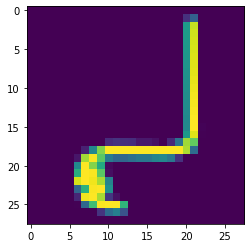

In [11]:
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28)) 
print(class_names[int(y_train[idx].item())])

### **Procesing the data**

In [12]:
# Reshape and normalize
from keras import utils as np_utils
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = np_utils.np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.np_utils.to_categorical(y_test, num_classes)

#keras.utils.np_utils.to_categorical

### **Model**
I am using the same pipeline of public repos and articles with already trained models.
https://medium.com/tensorflow/train-on-google-colab-and-run-on-the-browser-a-case-study-8a45f9b1474e

In [17]:
from tensorflow.keras.models import Sequential
model = Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(28, activation='relu'))
model.add(layers.Dense(len(class_names), activation='softmax')) 

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['top_k_categorical_accuracy'])
print(model.summary())
keras.__version__

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)              

'2.6.0'

### **Training**

In [14]:
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=10)

Epoch 1/10
1969/1969 - 68s - loss: 0.9878 - top_k_categorical_accuracy: 0.9252 - val_loss: 0.7416 - val_top_k_categorical_accuracy: 0.9513
Epoch 2/10
1969/1969 - 26s - loss: 0.6997 - top_k_categorical_accuracy: 0.9563 - val_loss: 0.6628 - val_top_k_categorical_accuracy: 0.9580
Epoch 3/10
1969/1969 - 28s - loss: 0.6366 - top_k_categorical_accuracy: 0.9618 - val_loss: 0.6211 - val_top_k_categorical_accuracy: 0.9622
Epoch 4/10
1969/1969 - 20s - loss: 0.6009 - top_k_categorical_accuracy: 0.9648 - val_loss: 0.6036 - val_top_k_categorical_accuracy: 0.9640
Epoch 5/10
1969/1969 - 31s - loss: 0.5758 - top_k_categorical_accuracy: 0.9668 - val_loss: 0.5856 - val_top_k_categorical_accuracy: 0.9645
Epoch 6/10
1969/1969 - 20s - loss: 0.5566 - top_k_categorical_accuracy: 0.9683 - val_loss: 0.5799 - val_top_k_categorical_accuracy: 0.9660
Epoch 7/10
1969/1969 - 32s - loss: 0.5420 - top_k_categorical_accuracy: 0.9697 - val_loss: 0.5742 - val_top_k_categorical_accuracy: 0.9663
Epoch 8/10
1969/1969 - 21s 

### **Testing**

In [15]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: {:0.2f}%'.format(score[1] * 100))

Test accuracy: 96.64%


<Figure size 432x288 with 0 Axes>

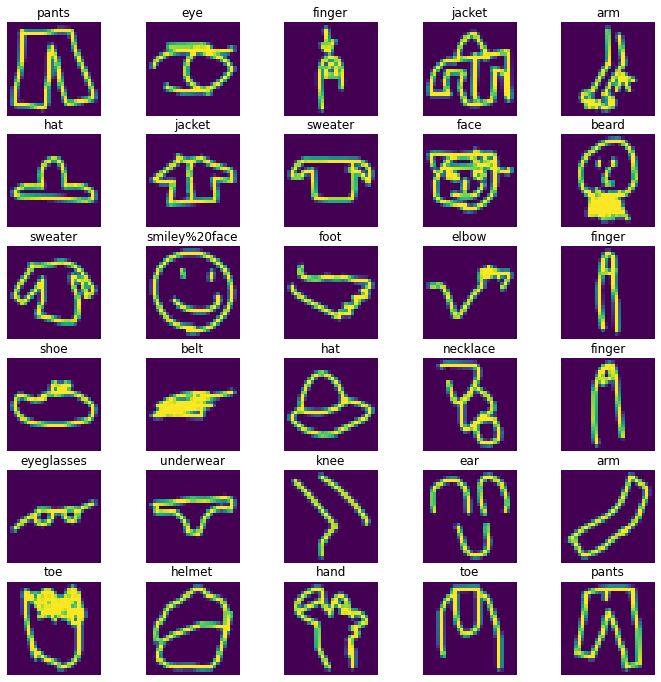

In [16]:
plt.subplots_adjust(hspace=0.5)
plt.figure(figsize=(12,12))

for i in range(30):
  #Random int 0-x_test.lenght to get an image
  rand = randint(0, len(x_test))
  img = x_test[rand]
  plt.subplot(6,5,i+1)
  plt.imshow(img.squeeze())  
  pred = model.predict(np.expand_dims(img, axis=0))[0]
  ind = (-pred).argsort()[:1]
  #Printing prediction
  plt.title(class_names[ind[0]])
  plt.axis('off')


